**Objective:** 

In this tutorial we will create a simple magnetic problem from scratch using the SimPEG framework.

We are using the integral form of the magnetostatic problem. In the absence of free-currents or changing magnetic field, magnetic material can give rise to a secondary magnetic field according to:

$$\vec b = \frac{\mu_0}{4\pi}  \int_{V}   \vec M \cdot \nabla \nabla \left(\frac{1}{r}\right) \; dV $$

Where $\mu_0$ is the magnetic permealitity of free-space, $\vec M$ is the magnetization per unit volume and $r$  defines the distance between the observed field $\vec b$ and the magnetized object. Assuming a purely induced response, the strenght of magnetization can be written as:

$$ \vec M = \mu_0 \kappa \vec H_0 $$

where $\vec H$ is an external inducing magnetic field, and $\kappa$ the magnetic susceptibility of matter.
As derived by Sharma 1966, the integral can be evaluated for rectangular prisms such that:

$$ \vec b(P) =  \mathbf{T} \cdot \vec H_0 \; \kappa $$

Where the tensor matrix $\bf{T}$ relates the three components of magnetization $\vec M$ to the components of the field $\vec b$:

$$\mathbf{T} =
	 \begin{pmatrix}
       		T_{xx} & T_{xy} & T_{xz}    \\
		T_{yx} & T_{yy} & T_{yz}    \\
		T_{zx} & T_{zy} & T_{zz}           
	\end{pmatrix} $$
    
In general, we discretize the earth into a collection of cells, each contributing to the magnetic data such that:

$$\vec b(P) = \sum_{j=1}^{nc} \mathbf{T}_j \cdot \vec H_0 \; \kappa_j$$

giving rise to a linear problem.


In [1]:
## Need to be on \pf\dev branch !!!
%pylab inline 
import SimPEG.PF as PF
from SimPEG import *
from SimPEG.Utils import io_utils

Populating the interactive namespace from numpy and matplotlib
Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    


In [2]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

In [3]:
# We first need to create a susceptibility model.
# Based on a set of parametric surfaces representing TKC, 
# we use VTK to discretize the 3-D space.

mshfile = 'MEsh_TEst.msh'

model_dir = '../../Geological_model/'

# Load mesh file
mesh = Mesh.TensorMesh.readUBC(model_dir+mshfile)

# Create our own mesh!
csx, csy, csz = 10., 10., 10.
ncx, ncy, ncz = 55, 55, 30
npad = 10
hx = [(csx,npad, -1.3),(csx,ncx),(csx,npad, 1.3)]
hy = [(csy,npad, -1.3),(csy,ncy),(csy,npad, 1.3)]
hz = [(csz,npad, -1.3),(csz,ncz), (10,20)]
mesh = Mesh.TensorMesh([hx, hy, hz],x0="CCN")
xc = 300+5.57e5
yc = 600+7.133e6
zc = 450.
x0_new = np.r_[mesh.x0[0]+xc, mesh.x0[1]+yc, mesh.x0[2]+zc]
mesh._x0 = x0_new

Mesh.TensorMesh.writeUBC(mesh,model_dir+"PF_mesh_UTM.msh")
# Define no-data-value
ndv = -100

# Define survey flight height
Z_bird = 20.

# Read in topo surface
topofile = model_dir+'TKCtopo.dat'
geosurf = [
    [model_dir+'Till.ts',True,True,0],
    [model_dir+'XVK.ts',True,True,1],
    [model_dir+'PK1.ts',True,True,2],
    [model_dir+'PK2.ts',True,True,3],
    [model_dir+'PK3.ts',True,True,4],
    [model_dir+'HK1.ts',True,True,5],
    [model_dir+'VK.ts',True,True,6]
]




../../Geological_model/PF_mesh_UTM.msh


In [4]:
import time as tm
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors
import scipy as sp
# from mayavi import mlab
# mlab.close(all=True)
# fig = plt.figure(figsize=(8,6))


# mlab.figure(bgcolor=(1.,1.,1.))
modelInd = np.ones(mesh.nC)*ndv
for ii in range(len(geosurf)):
    tin = tm.time()
    print "Computing indices with VTK: " + geosurf[ii][0]
    T, S = io_utils.read_GOCAD_ts(geosurf[ii][0])
    indx = io_utils.surface2inds(T,S,mesh, boundaries=geosurf[ii][1], internal=geosurf[ii][2])
    print "VTK operation completed in " + str(tm.time() - tin) + " sec"
    modelInd[indx] = geosurf[ii][3]
    
#     S = S-1
#     mlab.triangular_mesh(T[:,0], T[:,1], T[:,2], S)
#     mlab.view(azimuth=-45.,distance=1000,elevation=75.)

# arr = mlab.screenshot()

# plt.imshow(arr)

Computing indices with VTK: ../../Geological_model/Till.ts
Extracting indices from grid...
VTK operation completed in 28.1850001812 sec
Computing indices with VTK: ../../Geological_model/XVK.ts
Extracting indices from grid...
VTK operation completed in 5.34999990463 sec
Computing indices with VTK: ../../Geological_model/PK1.ts
Extracting indices from grid...
VTK operation completed in 13.1600000858 sec
Computing indices with VTK: ../../Geological_model/PK2.ts
Extracting indices from grid...
VTK operation completed in 5.3599998951 sec
Computing indices with VTK: ../../Geological_model/PK3.ts
Extracting indices from grid...
VTK operation completed in 7.12800002098 sec
Computing indices with VTK: ../../Geological_model/HK1.ts
Extracting indices from grid...
VTK operation completed in 12.5909998417 sec
Computing indices with VTK: ../../Geological_model/VK.ts
Extracting indices from grid...
VTK operation completed in 13.7820000648 sec


In [5]:
# Load topography file in UBC format and find the active cells
#T, S = io_utils.read_GOCAD_ts(topsurf)
#indx = io_utils.surface2inds(T,S, mesh, boundaries=True, internal=True) 
#actv = np.zeros(mesh.nC)
#actv[indx] = 1

topo = np.genfromtxt(topofile,skip_header=1)
# Find the active cells
actv = Utils.surface2ind_topo(mesh, topo, gridLoc='N')
# actv = PF.Magnetics.getActiveTopo(mesh,topo,'N')

# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, ndv)

print "Active cells created from topography!"

Active cells created from topography!


In [6]:
# Build model

def getModel(Till=0.0, XVK=2e-3, PK1=5e-3, PK2=2e-3, PK3=1e-3, HK1=2e-2, VK=1e-2, bkgr=0.):
    vals = [Till, XVK, PK1, PK2, PK3, HK1, VK]
    model= np.ones(mesh.nC) * bkgr

    for ii, sus in zip(range(7),vals):
        model[modelInd == ii] = sus
    return model
model = getModel()
sus = getModel()
model = model[actv]

In [7]:
from ipywidgets.widgets import interact, IntSlider

<function __main__.slide>

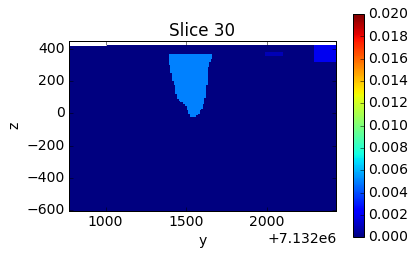

In [8]:
# Here you can visualize the current model
m_true = actvMap*model
Mesh.TensorMesh.writeModelUBC(mesh,model_dir+"Synthetic_mag.sus",m_true)
airc = m_true==ndv
m_true[airc] = np.nan
def slide(s,normal):
    colorbar(mesh.plotSlice(m_true, normal=normal, ind=s, clim=np.r_[model.min(), model.max()])[0])
    plt.gca().set_aspect('equal')
interact(slide, s=(0,60), normal=['X','Y','Z'])

**Forward system:**

Now that we have all our spatial components, we can create our linear system. For a single location and single component of the data, the system would looks like this:

$$ b_x =
	\begin{bmatrix}
	T_{xx}^1 &... &T_{xx}^{nc} & T_{xy}^1 & ... & T_{xy}^{nc} & T_{xz}^1 & ... & T_{xz}^{nc}\\
	 \end{bmatrix}
	 \begin{bmatrix}
		\mathbf{M}_x \\ \mathbf{M}_y \\ \mathbf{M}_z
	\end{bmatrix} \\ $$

where each of $T_{xx},\;T_{xy},\;T_{xz}$ are [nc x 1] long. For the $y$ and $z$ component, we need the two other rows of the tensor $\mathbf{T}$.
In our simple induced case, the magnetization direction $\mathbf{M_x,\;M_y\;,Mz}$ are known and assumed to be constant everywhere, so we can reduce the size of the system such that: 

$$ \vec{\mathbf{d}}_{\text{pred}} = (\mathbf{T\cdot M})\; \kappa$$



In most geophysical surveys, we are not collecting all three components, but rather the magnitude of the field, or $Total\;Magnetic\;Intensity$ (TMI) data.
Because the inducing field is really large, we will assume that the anomalous fields are parallel to $H_0$:

$$ d^{TMI}  = \hat H_0 \cdot \vec d$$

We then end up with a much smaller system:

$$ d^{TMI} = \mathbf{F\; \kappa}$$

where $\mathbf{F} \in \mathbb{R}^{nd \times nc}$ is our $forward$ operator.

In [9]:
from scipy.interpolate import NearestNDInterpolator
# We need to define the direction of the inducing field
# From old convention, field orientation is given as an azimuth from North 
# (positive clockwise) and dip from the horizontal (positive downward).
# The field parameters at TKC are [H:60,308 nT, I:83.8 d D:25.4 d ]
H0 = (60308.,83.8,25.4)

# We create a synthetic survey with observations in cell center.
X, Y = np.meshgrid(mesh.vectorCCx[npad:-npad:2], mesh.vectorCCy[npad:-npad:2])

# Using our topography, we trape the survey and shift it up by the flight height
Ftopo = NearestNDInterpolator(topo[:,:2], topo[:,2])
Z = Ftopo(Utils.mkvc(X.T),Utils.mkvc(Y.T)) + Z_bird

rxLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxLoc = PF.BaseMag.RxObs(rxLoc)

srcField = PF.BaseMag.SrcField([rxLoc])
srcField.param = H0
survey = PF.BaseMag.LinearSurvey(srcField)

In [10]:
# Now that we have a model and a survey we can build the linear system ...
nactv = np.int(np.sum(actv))

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP=nactv)

# Create the forward model operator
prob = PF.Magnetics.Problem3D_Integral(mesh, mapping=idenMap, actInd=actv, forwardOnly=False, rtype = 'tmi')

# Pair the survey and problem
survey.pair(prob)


Begin calculation of forward operator: ind
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!

Observation file saved to: MAG_Synthetic_data.obs


(-500, 500)

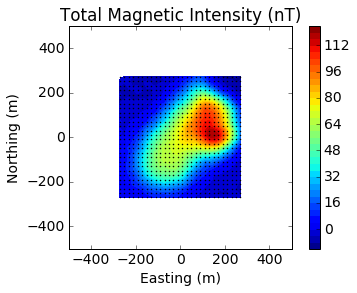

In [11]:
# Fist time that we ask for predicted data,
# the dense matrix T is calculated.
# This is generally the bottleneck of the integral formulation, 
# in terms of time and memory.
d = prob.fields(model)

# Add noise to the data and assign uncertainties
data = d + randn(len(d)) # We add some random Gaussian noise (1nT)
wd = np.ones(len(data))*1. # Assign flat uncertainties

survey.dobs = data
survey.std = wd

PF.Magnetics.writeUBCobs('MAG_Synthetic_data.obs',survey,data)

d2D = data.reshape(X.shape)
dat = plt.contourf(X-xc,Y-yc, d2D,40)    
plt.gca().set_aspect('equal')
plt.plot(X.flatten()-xc,Y.flatten()-yc,'k.', ms=2)
plt.colorbar(dat)    
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.title("Total Magnetic Intensity (nT)")
xlim(-500, 500)
ylim(-500, 500) 

In [12]:
# d2Dx, d2Dy, d2Dz = d[0:survey.nRx].reshape(X.shape), d[survey.nRx:2*survey.nRx].reshape(X.shape),  d[2*survey.nRx:].reshape(X.shape)


# plt.figure(figsize=[5,5])
# xc, yc = (X.min()+X.max())*0.5, (Y.min()+Y.max())*0.5
# #     colorbar(imshow(d2D,extent=[X.min()-xc, X.max()-xc, Y.min()-yc, Y.max()-yc],origin = 'lower'))
# #     plt.contour(X-xc,Y-yc, d2D,20,colors='k')
# # dat = plt.contourf(X-xc,Y-yc, d2Dz,40)

# # plt.gca().set_aspect('equal')


# mlab.figure(bgcolor=(1.,1.,1.))
# mlab.triangular_mesh(T[:,0], T[:,1], T[:,2], S)
# mlab.quiver3d(X,Y,Z,d2Dx, d2Dy, d2Dz, color)
# mlab.view(azimuth=-45.,distance=1500,elevation=75.)
# arr = mlab.screenshot()

# plt.imshow(arr)

**Inverse problem**

We have generated synthetic data, we now what to see if we can solve the inverse. Using the usual formulation, we seek a model that can reproduce the data, let’s say a least-squares measure of the form:

\begin{equation}
\phi_d =   \|\mathbf{W}_d \left( \mathbb{F}[\mathbf{m}] - \mathbf{d}^{obs} \right)\|_2^2
\end{equation}

The inverse problem is hard because we don’t have great data coverage, and the Earth is big, and there is usually noise in the data. So we need to add something to regularize it.
The simplest way to do it is to penalize solutions that won’t make sense geologically, for example to assume that the model is small.
The usual smooth inversion function use an l2-norm measure:

\begin{equation}
\phi_d =   \|\mathbf{W}_d \left( \mathbb{F}[\mathbf{m}] - \mathbf{d}^{obs} \right)\|_2^2 \\
\phi_m = \beta \Big [ {\| \mathbf{W}_s \;( \mathbf{m - m^{ref}})\|}^2_2  + \sum_{i = x,y,z}  {\|   \mathbf{W}_i  \; \mathbf{G}_i \; \mathbf{m}\|}^2_2  \Big ]\;,
\end{equation}

The full objective function to be minimized can be written as:
\begin{equation}
\phi(m) =  \phi_d + \beta \phi_m\;,
\end{equation}
which will yield our usual *small* and *smooth* models. 

We propose a fancier regularization function that can allow to recover *sparse* and *blocky* solutions.
Starting with the well known Ekblom norm:
\begin{equation}
\phi_m =  \sum_{i=1}^{nc} {(x_i^2 + \epsilon^2)}^{p/2} \;,
\end{equation}
where $x_i$ denotes some function of the model parameter, and $\epsilon$ is a small value to avoid singularity as $m\rightarrow0$.
For p=2, we get the usual least-squares measure and we recover the regularization presented above. For $p \leq 1$, the function becomes non-linear which requires some tweaking.

We can linearize the function by updating the penality function iteratively, commonly known as an Iterative Re-weighted Least-Squares (IRLS) method:
\begin{equation} 
\phi_m^{(k)} =  \frac{1}{2}\sum_{i=1}^{nc} r_i \; x_i^2
\end{equation}
where we added the superscript $\square^{(k)}$ to denote the IRLS iterations. The weights $r(x)$ are computed from model values obtained at a previous iteration such that:
\begin{equation}
	{r}_i  ={\Big( {({x_i}^{(k-1)})}^{2} + \epsilon^2 \Big)}^{p/2 - 1} \;,
\end{equation}
where ${r}(x) \in \mathbb{R}^{nc}$.

In matrix form, our objective function simply becomes:
\begin{equation}
\phi(m) =   \|\mathbf{W}_d \left( \mathbb{F}[\mathbf{m}] - \mathbf{d}^{obs} \right)\|_2^2 + \beta \Big [ {\| \mathbf{W}_s \;\mathbf{R}_s\;( \mathbf{m - m^{ref}})\|}^2_2  + \sum_{i = x,y,z}  {\|   \mathbf{W}_i\; \mathbf{R}_i  \; \mathbf{G}_i \; \mathbf{m}\|}^2_2  \Big ]\;,
\end{equation}
where the IRLS weights $\mathbf{R}_s$ and $\mathbf{R}_i$ are diagonal matrices defined as:
\begin{equation}
\begin{split}
	{R}_{s_{jj}}  &=  \sqrt{\eta_p}{\Big[ {({m_j}^{(k-1)})}^{2} + \epsilon_p^2 \Big]}^{(p/2 - 1)/2} \\
	{R}_{i_{jj}}  &=  \sqrt{\eta_q}{\Big[ {\left ({{(G_i\;m^{(k-1)})}_j }\right)}^{2} + \epsilon_q^2 \Big]}^{(q/2 - 1)/2} \\
\eta_p &=  {\epsilon_p}^{(1-p/2)} \\
\eta_q &=   {\epsilon_q}^{(1-q/2)}  \;, 
\end{split}
\end{equation}

we added two scaling parameters $\eta_p$ and $\eta_q$ for reasons that we won't dicuss here, but turn out to be important to get stable solves.

In order to initialize the IRLS and get an estimate for the stabilizing parameters $\epsilon_p$ and $\epsilon_q$, we first invert with the smooth $l_2$-norm. 
The whole IRLS process is implemented with a directive added to the inversion workflow (see below).


In [13]:
# It is potential fields, so we will need to push the inverison down
# Create distance weights from our linera forward operator
wr = np.sum(prob.G**2.,axis=0)**0.5
wr = ( wr/np.max(wr) )
#wr = PF.Magnetics.get_dist_wgt(mesh, survey.srcField.rxList[0].locs, actv, 3., np.min(mesh.hx)/4.)
#wr = wr**2. # Need to square to be included as weights
    
reg = Regularization.Sparse(mesh, indActive = actv, mapping = idenMap)
reg.cell_weights = wr

dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1/wd

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100 ,lower=0.,upper=1., maxIterLS = 20, maxIterCG= 10, tolCG = 1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
eps = [3e-4,3e-4] # Threshold parameters to penalize different model parameters
norms = [0,1,1,1] # Norms applies on the model and 3 gradients [p, qx, qy, qz]


IRLS = Directives.Update_IRLS( norms=norms,  eps=eps, f_min_change = 1e-1, minGNiter=6)
update_Jacobi = Directives.Update_lin_PreCond()
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,betaest,update_Jacobi])

m0 = np.ones(idenMap.nP)*1e-4


In [14]:
# Run inversion...
mrec = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  1.18e+09  6.86e+05  0.00e+00  6.86e+05    4.76e+02      0              
   1  5.89e+08  5.68e+05  4.45e-05  5.94e+05    4.73e+02      0              
   2  2.95e+08  4.63e+05  1.61e-04  5.11e+05    4.68e+02      0   Skip BFGS  
   3  1.47e+08  3.49e+05  4.31e-04  4.12e+05    4.62e+02      0   Skip BFGS  
   4  7.36e+07  2.35e+05  9.74e-04  3.06e+05    4.50e+02      0   Skip BFGS  
   5  3.68e+07  1.41e+05  1.85e-03  2.09e+05    4.32e+02      0   Skip BFGS  
   6  1.84e+07  7.56e+04  3.06e-03  1.32e+05    4.10e+02      0   Skip BFGS  
   7  9.21e+06  

In [15]:
# Get the final model back to full space
m_lp = actvMap*mrec
m_lp[airc] = np.nan

# Get the smooth model aslo
m_l2 = actvMap*reg.l2model
m_l2[airc] = np.nan

# Save both models to file
Mesh.TensorMesh.writeModelUBC(mesh,'SimPEG_MAG_l2l2.sus',m_l2)
Mesh.TensorMesh.writeModelUBC(mesh,'SimPEG_MAG_lplq.sus',m_lp)

<function __main__.slide>

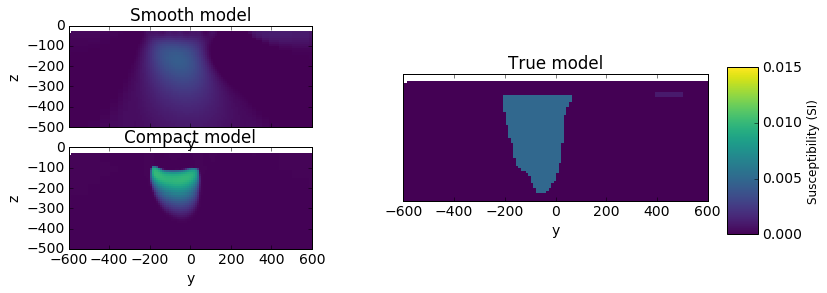

In [16]:
# Plot the recoverd models 
vmin, vmax = 0., 0.015

mesh = Mesh.TensorMesh([mesh.hx, mesh.hy, mesh.hz],x0="CCN")

def slide(s,normal):
    
    if normal == "Z":
        fig = plt.figure(figsize(10*1.2, 8))
    else:
        fig = plt.figure(figsize(10*1.2, 4))
        
    ax1 = plt.subplot(2,2,3)
    dat = mesh.plotSlice(m_lp, ax = ax1, normal=normal, ind=s, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
    plt.gca().set_aspect('equal')
    plt.title('Compact model')
    
    if normal == "Z":
        xlim(-600, 600)
        ylim(-600, 600.)    
    else:
        xlim(-600, 600)
        ylim(-500, 0.) 
        
    ax2 = plt.subplot(2,2,1)
    dat = mesh.plotSlice(m_l2, ax = ax2, normal=normal, ind=s, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
    plt.gca().set_aspect('equal')
    plt.title('Smooth model')
    
    if normal == "Z":
        xlim(-600, 600)
        ylim(-600, 600.)    
    else:
        xlim(-600, 600)
        ylim(-500, 0.) 
        
    ax2.set_xticklabels([])
        
    ax2 = plt.subplot(1,2,2)
    dat = mesh.plotSlice(m_true, ax = ax2, normal=normal, ind=s, clim=np.r_[vmin, vmax],pcolorOpts={'cmap':'viridis'})
#     plt.colorbar(dat[0])
    plt.gca().set_aspect('equal')
    plt.title('True model')
    
    pos =  ax2.get_position()

    ax2.yaxis.set_visible(False)
    if normal == "Z":
        xlim(-600, 600)
        ylim(-600, 600.) 
        ax2.set_position([pos.x0 -0.04 , pos.y0,  pos.width, pos.height])
    else:
        xlim(-600, 600)
        ylim(-500, 0.) 

    pos =  ax2.get_position()
    cbarax = fig.add_axes([pos.x0 + 0.375 , pos.y0 + 0.05,  pos.width*0.1, pos.height*0.75])  ## the parameters are the specified position you set
    cb = fig.colorbar(dat[0],cax=cbarax, orientation="vertical", ax = ax2, ticks=np.linspace(vmin,vmax, 4))
    cb.set_label("Susceptibility (SI)",size=12)
    fig.savefig('PF_Compact.png',dpi = 150)
    
interact(slide, s=(0,60), normal=['X','Y','Z'])

# interact(lambda ind: viz(m_l2, ind, normal="Z"), ind=IntSlider(min=0, max=32,step=1, value=28))


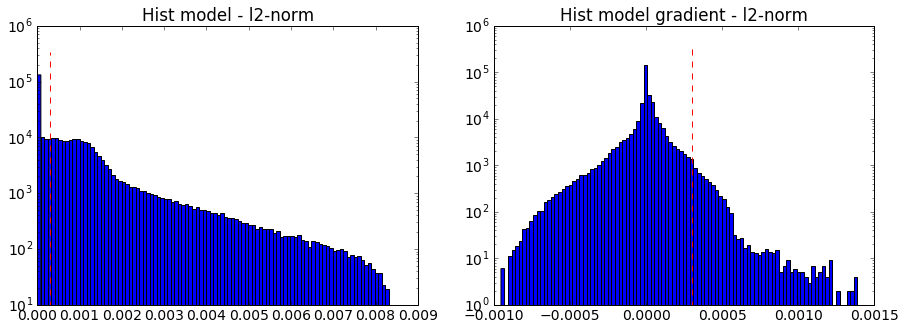

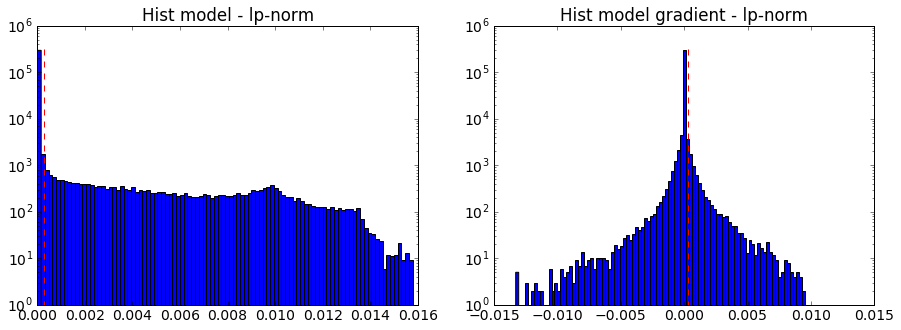

In [17]:
# Lets compare the distribution of model parameters and model gradients
plt.figure(figsize=[15,5])
ax = plt.subplot(121)
plt.hist(reg.l2model,100)
plt.plot((eps[0],eps[0]),(0,mesh.nC),'r--')
plt.yscale('log', nonposy='clip')
plt.title('Hist model - l2-norm')
ax = plt.subplot(122)
plt.hist(reg.regmesh.cellDiffxStencil*reg.l2model,100)
plt.plot((eps[1],eps[1]),(0,mesh.nC),'r--')
plt.yscale('log', nonposy='clip')
plt.title('Hist model gradient - l2-norm')

# Lets look at the distribution of model parameters and model gradients
plt.figure(figsize=[15,5])
ax = plt.subplot(121)
plt.hist(mrec,100)
plt.plot((eps[0],eps[0]),(0,mesh.nC),'r--')
plt.yscale('log', nonposy='clip')
plt.title('Hist model - lp-norm')
ax = plt.subplot(122)
plt.hist(reg.regmesh.cellDiffxStencil*mrec,100)
plt.plot((eps[1],eps[1]),(0,mesh.nC),'r--')
plt.yscale('log', nonposy='clip')
plt.title('Hist model gradient - lp-norm')

In [18]:
Mesh.MeshIO.TensorMeshIO.writeUBC(mesh,'MAG_mesh.msh')

# import pickle
# Results = {"mesh":mesh, "model_true":sus, "model_pred":m_IRLS, "Obs":data, "XYZ": xyz}
# outputs = open("Magresults", 'wb')
# pickle.dump(Results, outputs)
# outputs.close()